In [1]:
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import chromadb
import numpy as np
import os
import matplotlib.pyplot as plt

/Users/nnandagopal/Desktop/personal_projects/paperbot/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Specify your custom directory
custom_cache_dir = "./model_cache_dir"
model_name = "openai/clip-vit-large-patch14"

# Load the CLIP model and processor
model = CLIPModel.from_pretrained(model_name, cache_dir=custom_cache_dir)
processor = CLIPProcessor.from_pretrained(model_name, cache_dir=custom_cache_dir)

In [4]:
def load_image(image_path):
    image = Image.open(image_path)
    return image

def compute_image_embeddings(image):
    # Preprocess the image (resize, normalize, etc.)
    inputs = processor(images=image, return_tensors="pt")
    # Generate image embeddings
    with torch.no_grad():
        image_embeddings = model.get_image_features(**inputs)

    return image_embeddings[0]


# Function to calculate text embeddings
def compute_text_embedding(text):
    # Preprocess the text
    inputs = processor(text=[text], return_tensors="pt", padding=True)

    # Get text embeddings
    with torch.no_grad():
        text_embeddings = model.get_text_features(**inputs)

    return text_embeddings[0]


# Convert tensor to list if needed
def tensor_to_list(embedding_tensor):
    if not isinstance(embedding_tensor, (list, np.ndarray)):
        embedding_tensor = embedding_tensor.tolist()  # Convert tensor to list
    return embedding_tensor


In [5]:
# Initialize Chroma client
client = chromadb.PersistentClient()

# Create or get a collection to store the embeddings and metadata
collection = client.create_collection(name="image_embeddings", get_or_create=True)

collection.count()

0

In [6]:
# Store image, embeddings, and metadata in ChromaDB
def store_image_in_db(image_path, image_id, metadata=None):
    image = load_image(image_path)
    embedding_tensor = compute_image_embeddings(image)
    embedding = tensor_to_list(embedding_tensor)

    # Store the image embedding and metadata in ChromaDB
    collection.add(
        documents=[image_path],  # You can store the image path or a URL as a reference
        embeddings=[embedding],  # Store the embedding vector here
        metadatas=[metadata or {}],  # Metadata can be any additional information, like tags
        ids=[image_id]  # Unique ID for the image
    )
    print(f"Image {image_id} stored successfully.")

In [7]:
# Function to open and display images individually
def display_images_individually(image_paths):
    for path in image_paths:
        img = Image.open(path)  # Open the image file
        plt.figure(figsize=(4, 4))  # Set the figure size for individual display
        plt.imshow(img)  # Display the image
        plt.axis('off')  # Turn off the axis
        plt.title(path.split('/')[-1])  # Add title with image name
        plt.show()  # Show the image

In [8]:
# Define the directory path
directory = 'images/'

# Loop through all files in the directory
for filename in os.listdir(directory):
    # Construct full file path
    file_path = os.path.join(directory, filename)
    
    # Check if it's a file (not a directory)
    if os.path.isfile(file_path):
        print(f"Processing file: {file_path}")
        store_image_in_db(file_path,filename, metadata={"type": "image"})


Processing file: images/0878.png
Image 0878.png stored successfully.
Processing file: images/0850.png
Image 0850.png stored successfully.
Processing file: images/0844.png
Image 0844.png stored successfully.
Processing file: images/0893.png
Image 0893.png stored successfully.
Processing file: images/0887.png
Image 0887.png stored successfully.
Processing file: images/0886.png
Image 0886.png stored successfully.
Processing file: images/0845.png
Image 0845.png stored successfully.
Processing file: images/0851.png
Image 0851.png stored successfully.
Processing file: images/0879.png
Image 0879.png stored successfully.
Processing file: images/0847.png
Image 0847.png stored successfully.
Processing file: images/0853.png
Image 0853.png stored successfully.
Processing file: images/0884.png
Image 0884.png stored successfully.
Processing file: images/0890.png
Image 0890.png stored successfully.
Processing file: images/0891.png
Image 0891.png stored successfully.
Processing file: images/0885.png
I

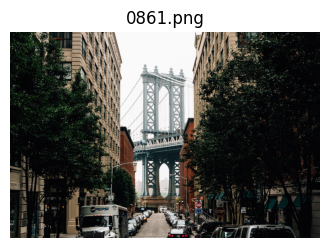

In [11]:
# validation with image
test_image_path = 'images/0861.png'

display_images_individually([test_image_path])

image = load_image(test_image_path)
embedding_tensor = compute_image_embeddings(image)
embedding = tensor_to_list(embedding_tensor)


In [25]:
query_text = 'mushrooms'

embedding_tensor = compute_text_embedding(query_text)
embedding = tensor_to_list(embedding_tensor)

['images/0839.png', 'images/0858.png', 'images/0815.png']


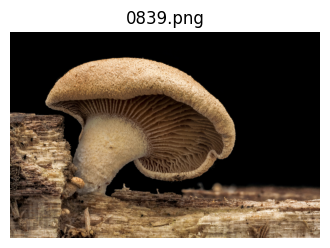

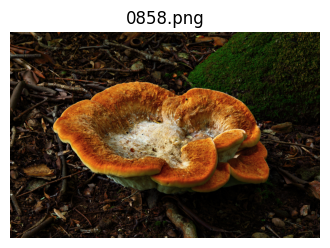

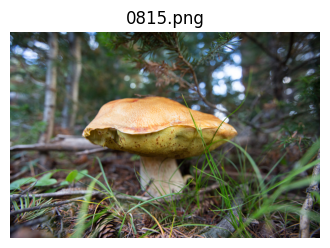

In [26]:
results = collection.query(query_embeddings=[embedding], n_results=3)

# Extract image names
image_paths = results['documents'][0]  # Access the first list in the documents field

# Output the result
print(image_paths)

# Call the function to display the images
display_images_individually(image_paths)